In [1]:
import itertools
from datetime import datetime

import submitit 

from elk_experiments.utils import repo_path_to_abs_path, OUTPUT_DIR
from auto_circuit.tasks import (
    IOI_TOKEN_CIRCUIT_TASK, 
    IOI_COMPONENT_CIRCUIT_TASK, 
    IOI_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    DOCSTRING_TOKEN_CIRCUIT_TASK, 
    DOCSTRING_COMPONENT_CIRCUIT_TASK, 
    GREATERTHAN_COMPONENT_CIRCUIT_TASK, 
    GREATERTHAN_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    ANIMAL_DIET_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK
)
from auto_circuit.types import AblationType
from elk_experiments.auto_circuit.score_funcs import GradFunc, AnswerFunc

# Specify Settings / Hyperpameters

In [2]:
#specify the hyperparameters
tasks = [
    IOI_TOKEN_CIRCUIT_TASK, 
    IOI_COMPONENT_CIRCUIT_TASK, 
    DOCSTRING_TOKEN_CIRCUIT_TASK, 
    DOCSTRING_COMPONENT_CIRCUIT_TASK, 
    GREATERTHAN_COMPONENT_CIRCUIT_TASK, 
    # IOI_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    # GREATERTHAN_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    # ANIMAL_DIET_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK
]
use_abs = [True, False]
ablation_types = [
    AblationType.RESAMPLE, 
    AblationType.TOKENWISE_MEAN_CLEAN,
    AblationType.TOKENWISE_MEAN_CORRUPT, 
    AblationType.TOKENWISE_MEAN_CLEAN_AND_CORRUPT,
    AblationType.ZERO
]
grad_funcs = [
    GradFunc.LOGIT, 
    GradFunc.LOGPROB
]
answer_funcs = [
    AnswerFunc.MAX_DIFF, 
    AnswerFunc.AVG_VAL
]

use_abs_to_epsilon = {
    True: [0.1], 
    False: [0.0, -0.4]
}

# generate all combinations
combinations = [
    {
        "task": f"'{task.key}'",
        "use_abs": use_ab,
        "ablation_type": ablation_type.name,
        "grad_func": grad_func.name,
        "answer_func": answer_func.name,
        "epsilon": epsilon
    }
    for task, use_ab, ablation_type, grad_func, answer_func in itertools.product(
        tasks,
        use_abs,
        ablation_types,
        grad_funcs,
        answer_funcs
    )
    for epsilon in use_abs_to_epsilon[use_ab]
]

# combinations = [
#     {
#         "task": f"'{IOI_TOKEN_CIRCUIT_TASK.key}'",
#         "use_abs": False,
#         "ablation_type": AblationType.TOKENWISE_MEAN_CORRUPT.name,
#         "grad_func": GradFunc.LOGPROB.name,
#         "answer_func": AnswerFunc.AVG_VAL.name,
#         "epsilon": 0.0
#     }
# ]

# Setup Executor and Run

In [3]:
# setup the executor
out_dir = repo_path_to_abs_path(OUTPUT_DIR / "hypo_test_out_logs" / datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
out_dir.mkdir(exist_ok=True, parents=True)
executor = submitit.AutoExecutor(folder=out_dir)
executor.update_parameters(
    timeout_min=60*24,
    mem_gb=40,
    gres="gpu:1",
    cpus_per_task=8,
    nodes=1,
    slurm_qos="high", 
    slurm_array_parallelism=4
)


/nas/ucb/oliveradk/miniforge3/envs/elk-experiments/lib/python3.10/site-packages/submitit/auto/auto.py:23: UserWarning: Setting 'gres' is deprecated. Use 'slurm_gres' instead.
  warnings.warn(f"Setting '{arg}' is deprecated. Use '{new_arg}' instead.")


In [4]:
# run the jobs
with executor.batch():
    jobs = []
    for combo in combinations:
        function = submitit.helpers.CommandFunction(
            ["python", "scripts/hypothesis_tests.py"] + [
                f"{key}={value}" for key, value in combo.items()
            ], 
            cwd=repo_path_to_abs_path(".")
        )
        jobs.append(executor.submit(function))

In [5]:
from submitit.slurm.slurm import SlurmJob
from pathlib import Path    
def get_std_out_error_paths(job: SlurmJob):
    prefix = f"{job._paths._folder}/{job.job_id}_{job.task_id}_log"
    return Path(prefix + ".out"), Path(prefix + ".err")

In [7]:
std_out, std_err = get_std_out_error_paths(jobs[0])

In [23]:
# read stdout and stderr
print(std_out.read_text())

submitit INFO (2024-08-09 00:40:25,337) - Starting with JobEnvironment(job_id=421909_0, hostname=sac.ist.berkeley.edu, local_rank=0(1), node=0(1), global_rank=0(1))
submitit INFO (2024-08-09 00:40:25,337) - Loading pickle: /nas/ucb/oliveradk/elk-experiments/output/hypo_test_out_logs/2024-08-08_17-40-22/421909_0_submitted.pkl
The following command is sent: "python scripts/hypothesis_tests.py task='Indirect Object Identification Token Circuit' use_abs=True ablation_type=RESAMPLE grad_func=LOGIT answer_func=MAX_DIFF epsilon=0.1"
Loaded pretrained model gpt2-small into HookedTransformer
seq_len before divergence 15
seq_len after divergence 13
Saving cache to /nas/ucb/oliveradk/elk-experiments/output/hypo_test_results/Indirect_Object_Identification_Token_Circuit_RESAMPLE_LOGIT_MAX_DIFF_10/True_0.05_0.1_0.9/prune_scores-09-08-2024_00-40-49.pkl
interval: 0 - 422383
width 10000
interval: 0 - 10000
width 1000
interval: 0 - 1000
width 100
interval: 0 - 100
width 10
interval: 90 - 100
width 1
Sav

In [29]:
len(combinations) / 4 * 5 / 60 # roughly 6 hours

6.25

# Analysize Results

## Pathologies of Ablations and Score Functions

- explore some examples on IOI in depth, show how e.g. mean clean ablation just attends from source to test for avg val, similar for max value
- zero ablation requires almost every edge, too out of distribution
- mean corrupt leads to more "task identification" mechanisms
- resample ablation allows for patching edges not reached by input, is in this sense more natural (someone has said this before), but also higher variance and less general (constructing contrast pairs is expensive)

## Synergies Between Score Functions and Ablation Methodologies

In [5]:
# I want to plot fraction of edges required for faithfulness, with bar plot seperated by ablation methodology and and score func (
    # generate different plot per answer function

In [6]:
from auto_circuit.tasks import Task
def get_exp_dir(
    task: Task, 
    ablation_type: AblationType,
    grad_func: GradFunc,
    answer_func: AnswerFunc,
    ig_samples: int, 
    use_abs: bool,
    alpha: float,
    epsilon: float,
    q_star: float
):
    return repo_path_to_abs_path(
        OUTPUT_DIR / "hypo_test_results" / f"{task.key.replace(' ', '_')}_{ablation_type.name}_{grad_func.name}_{answer_func.name}_{ig_samples}" / f"{use_abs}_{alpha}_{epsilon}_{q_star}"
    )

In [39]:
import json
from collections import defaultdict
use_abs_default = True 
ig_default = 10
alpha_default = 0.05
q_star_default = 0.9
epsilon_default = use_abs_to_epsilon[use_abs_default][0]
grad_func_default = GradFunc.LOGPROB
considered_tasks = [IOI_TOKEN_CIRCUIT_TASK, DOCSTRING_TOKEN_CIRCUIT_TASK]
considered_answer_funcs = [AnswerFunc.MAX_DIFF, AnswerFunc.AVG_VAL]
considered_ablation_types = [AblationType.RESAMPLE, AblationType.TOKENWISE_MEAN_CORRUPT]

# log frac of total edges needed 

frac_total_edges = defaultdict(dict) # dictionary from 
for task in considered_tasks: 
    for ablation_type, answer_func in itertools.product(considered_ablation_types, considered_answer_funcs):
        # get path to results 
        exp_path = get_exp_dir(task, ablation_type, grad_func_default, answer_func, ig_default, use_abs_default, alpha_default, epsilon_default, q_star_default)
        # load equiv test results 
        with open(exp_path / "equiv_results.json", "r") as f:
            equiv_test_results: dict[int, dict] = json.load(f)
        min_equiv = min([int(edge_count) for edge_count, result in equiv_test_results.items() if not result["not_equiv"]])
        total_edges = max([int(edge_count) for edge_count in equiv_test_results.keys()])
        frac_total_edges[task.key][(ablation_type, answer_func)] = (min_equiv / total_edges, min_equiv, total_edges)


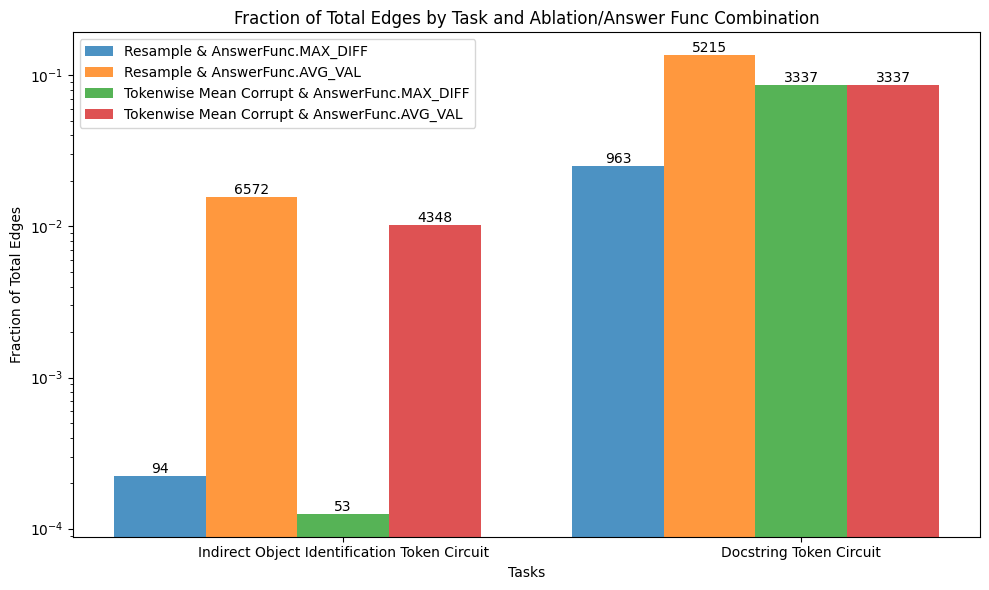

In [40]:
import matplotlib.pyplot as plt
import numpy as np
# Preparing data for plotting
ablation_answer_combinations = list(itertools.product(considered_ablation_types, considered_answer_funcs))
n_tasks = len(considered_tasks)
n_combinations = len(ablation_answer_combinations)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
index = np.arange(n_tasks)
bar_width = 0.2
opacity = 0.8

for i, combination in enumerate(ablation_answer_combinations):
    values = [frac_total_edges[task.key][combination][0] for task in considered_tasks]
    labels = [frac_total_edges[task.key][combination][1] for task in considered_tasks]
    bars = plt.bar(index + i * bar_width, values, bar_width,
            alpha=opacity,
            label=f'{combination[0]} & {combination[1]}')

    # Adding labels above each bar
    for bar, label in zip(bars, labels):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), label,
                ha='center', va='bottom')

# Labels and titles
plt.xlabel('Tasks')
plt.ylabel('Fraction of Total Edges')
plt.title('Fraction of Total Edges by Task and Ablation/Answer Func Combination')
plt.xticks(index + bar_width * (n_combinations / 2), [t.key for t in considered_tasks])
plt.legend()

plt.yscale('log')

plt.tight_layout()
plt.show()

In [16]:
# pl
frac_total_edges

defaultdict(dict,
            {'Indirect Object Identification Token Circuit': {(<AblationType.RESAMPLE: 1>,
               <AnswerFunc.MAX_DIFF: 'max_diff'>): 0.00022254683545502543,
              (<AblationType.RESAMPLE: 1>,
               <AnswerFunc.AVG_VAL: 'avg_val'>): 0.015559338325642841,
              (<AblationType.TOKENWISE_MEAN_CORRUPT: 4>,
               <AnswerFunc.MAX_DIFF: 'max_diff'>): 0.00012547853488421645,
              (<AblationType.TOKENWISE_MEAN_CORRUPT: 4>,
               <AnswerFunc.AVG_VAL: 'avg_val'>): 0.010293974899557985},
             'Docstring Token Circuit': {(<AblationType.RESAMPLE: 1>,
               <AnswerFunc.MAX_DIFF: 'max_diff'>): 0.02505854800936768,
              (<AblationType.RESAMPLE: 1>,
               <AnswerFunc.AVG_VAL: 'avg_val'>): 0.13570127504553733,
              (<AblationType.TOKENWISE_MEAN_CORRUPT: 4>,
               <AnswerFunc.MAX_DIFF: 'max_diff'>): 0.08683320322664585,
              (<AblationType.TOKENWISE_MEAN_CORRUPT: 4>,


## Minimality / Completeness Tradeoff